# Visualizing the Cluster Structure

We know the cluster has 2,212 tokens compressed into 125 unique vectors. Let's look at where these points actually are.

Strategy:
- Load unique cluster vectors (in bfloat16)
- Find the two dimensions with greatest spread
- Plot the raw component values
- No centering, no PCA, no projections—just look at the thickest cross-section

## Parameters

In [ ]:
# Paths
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Dimension selection
DIM_INDICES = (0, 1)  # Plot dimension rank 0 vs rank 1 by variance

# Visualization
DIAMETER = None  # Width/height of plot window (None = auto-fit to data)
POINT_SIZE = 100  # Base point size
SIZE_SCALE = 5.0  # Multiplier for population-based sizing
COLORMAP = 'plasma'
DPI = 200

## Imports

In [402]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt

## Device Detection

In [403]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [404]:
# Load cluster token IDs
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"Loaded {len(cluster_token_ids)} cluster token IDs")

Loaded 2212 cluster token IDs


In [405]:
# Load gamma matrix in bfloat16
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.bfloat16).to(device)

print(f"Loaded gamma matrix: {W.shape}")
print(f"Precision: {W.dtype}")

Loaded gamma matrix: torch.Size([151936, 2560])
Precision: torch.bfloat16


In [406]:
# Extract cluster vectors
cluster_vectors = W[cluster_token_ids]

print(f"Extracted {cluster_vectors.shape[0]} vectors of dimension {cluster_vectors.shape[1]}")

Extracted 2212 vectors of dimension 2560


## Find Unique Vectors and Populations

In [407]:
# Find unique vectors (stay in bfloat16)
unique_vectors, inverse_indices = torch.unique(cluster_vectors.to('cpu'), dim=0, return_inverse=True)
unique_vectors = unique_vectors.to(device)
inverse_indices = inverse_indices.to(device)

populations = torch.bincount(inverse_indices)

print(f"Found {len(unique_vectors)} unique vectors")
print(f"Precision: {unique_vectors.dtype}")
print(f"Population range: {populations.min().item()} to {populations.max().item()}")

Found 125 unique vectors
Precision: torch.bfloat16
Population range: 1 to 814


## Select Dimensions by Variance

In [408]:
# Compute variance across each dimension (no centering - raw variance)
variances = torch.var(unique_vectors.to(torch.float32), dim=0)

# Rank dimensions by variance
ranked_dims = torch.argsort(variances, descending=True)

# Select dimensions to plot
dim_x = ranked_dims[DIM_INDICES[0]].item()
dim_y = ranked_dims[DIM_INDICES[1]].item()

print(f"Selected dimensions:")
print(f"  X-axis: dimension {dim_x} (variance rank {DIM_INDICES[0]})")
print(f"  Y-axis: dimension {dim_y} (variance rank {DIM_INDICES[1]})")
print(f"\nVariances:")
print(f"  X: {variances[dim_x].item():.6e}")
print(f"  Y: {variances[dim_y].item():.6e}")

Selected dimensions:
  X-axis: dimension 163 (variance rank 0)
  Y-axis: dimension 13 (variance rank 1)

Variances:
  X: 1.907349e-09
  Y: 4.768372e-10


## Extract Raw Coordinates

In [409]:
# Extract raw bfloat16 component values (no processing)
x_coords = unique_vectors[:, dim_x].to(torch.float32).cpu().numpy()
y_coords = unique_vectors[:, dim_y].to(torch.float32).cpu().numpy()

print(f"X-coordinate range: [{x_coords.min():.6e}, {x_coords.max():.6e}]")
print(f"Y-coordinate range: [{y_coords.min():.6e}, {y_coords.max():.6e}]")
print(f"\nNumber of unique X values: {len(np.unique(x_coords))}")
print(f"Number of unique Y values: {len(np.unique(y_coords))}")

X-coordinate range: [-8.056641e-02, -8.007812e-02]
Y-coordinate range: [-4.760742e-02, -4.736328e-02]

Number of unique X values: 2
Number of unique Y values: 2


## Visualize

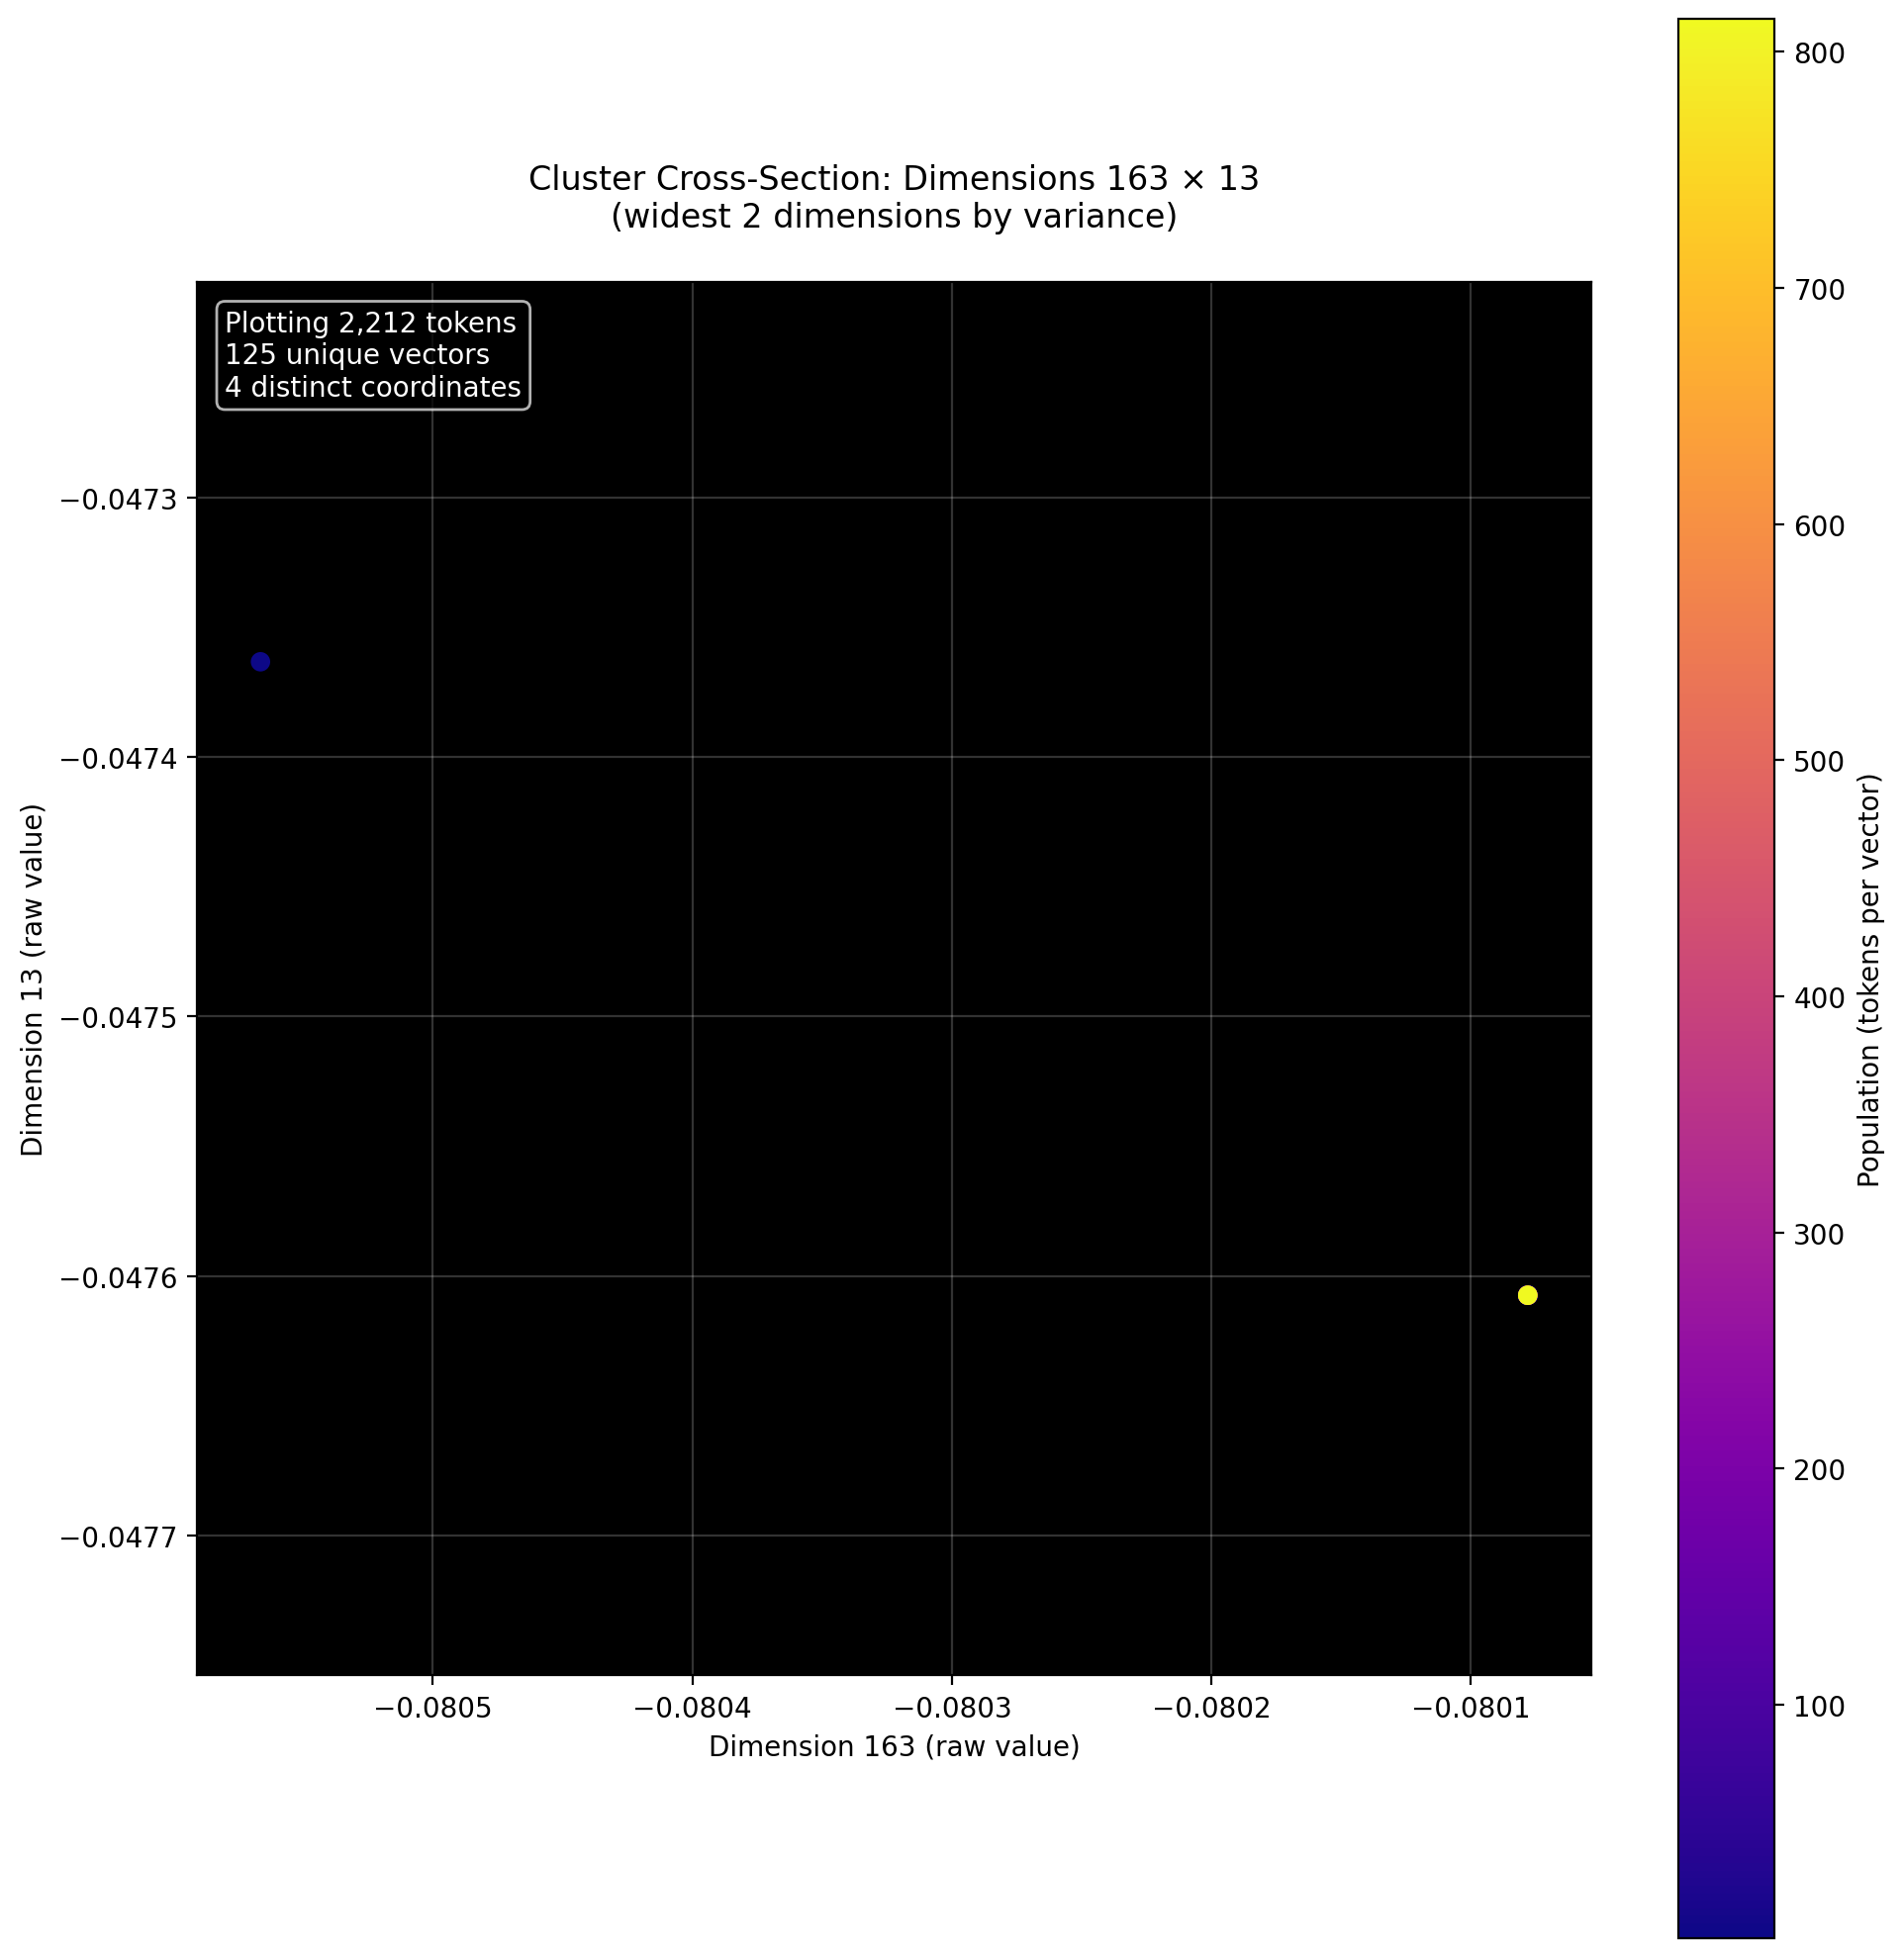


Plot window:
  Center: (-8.032227e-02, -4.748535e-02)
  Diameter: 5.371094e-04


In [411]:
# Compute plot window
x_min, x_max = x_coords.min(), x_coords.max()
y_min, y_max = y_coords.min(), y_coords.max()
x_mid = (x_min + x_max) / 2
y_mid = (y_min + y_max) / 2

if DIAMETER is None:
    # Auto-fit: use data extent with 10% padding
    x_extent = x_max - x_min
    y_extent = y_max - y_min
    diameter = max(x_extent, y_extent) * 1.1
else:
    diameter = DIAMETER

half_width = diameter / 2

# Prepare populations
populations_cpu = populations.cpu().numpy()

# Sort by population (smallest first, so largest appear on top)
sort_indices = np.argsort(populations_cpu)
x_sorted = x_coords[sort_indices]
y_sorted = y_coords[sort_indices]
populations_sorted = populations_cpu[sort_indices]

# Scale point sizes by population
sizes_sorted = POINT_SIZE + SIZE_SCALE * populations_sorted

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=DPI)

# Black background
ax.set_facecolor('black')

# Scatter plot
scatter = ax.scatter(
    x_sorted,
    y_sorted,
    c=populations_sorted,
    s=50.0,
    cmap=COLORMAP,
    edgecolors='none',
)

# Annotation box showing degeneracy
num_unique_coords = len(np.unique(x_coords)) * len(np.unique(y_coords))
annotation_text = (
    f'Plotting {len(cluster_vectors):,} tokens\n'
    f'{len(unique_vectors)} unique vectors\n'
    f'{num_unique_coords} distinct coordinates'
)
ax.text(
    0.02, 0.98,
    annotation_text,
    transform=ax.transAxes,
    verticalalignment='top',
    color='white',
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='black', alpha=0.7, edgecolor='white')
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Population (tokens per vector)', color='black')
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

# Set limits based on diameter
ax.set_xlim(x_mid - half_width, x_mid + half_width)
ax.set_ylim(y_mid - half_width, y_mid + half_width)

# Equal aspect ratio
ax.set_aspect('equal')

# Labels and title
ax.set_xlabel(f'Dimension {dim_x} (raw value)', color='black')
ax.set_ylabel(f'Dimension {dim_y} (raw value)', color='black')
ax.set_title(
    f'Cluster Cross-Section: Dimensions {dim_x} × {dim_y}\n'
    f'(widest 2 dimensions by variance)',
    color='black', pad=20
)

# Black tick labels
ax.tick_params(colors='black')

# Grid
ax.grid(True, alpha=0.2, color='white')

plt.tight_layout()
plt.show()

print(f"\nPlot window:")
print(f"  Center: ({x_mid:.6e}, {y_mid:.6e})")
print(f"  Diameter: {diameter:.6e}")